<a href="https://colab.research.google.com/github/HwangHanJae/ml-definitive-guide-pratice/blob/main/evaluation_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#분류의 평가방법(분류에 사용되는 평가지표)
- 정확도(Accuracy)
- 오차행렬(Confusion Matrix)
- 정밀도(Precision)
- 재현율(Recall)
- F1 스코어
- ROC AUC

6개의 지표모두 이진 분류에서 더욱 중요하게 강조하는 지표

##정확도(Accuracy)

$$\frac{TN+TP}{TP+TN+FN+FP}$$

$$ \frac{예측\;결과가\;동일한\;데이터\;건수}{전체\;예측\;데이터\;건수}$$


In [ ]:
#정확도만 사용하면 안되는 경우
from sklearn.base import BaseEstimator
import numpy as np
class MyDummyClassifier(BaseEstimator):
  #fit() 메서드는 아무것도 학습하지 않음
  def fit(self, X, y=None):
    pass
  #predict 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
  def predict(self, X):
    pred = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
      if X["Sex"].iloc[i] == 1:
        pred[i] =0
      else:
        pred[i] = 1
    return pred

In [3]:
#@title
#위에서 했던 작업들을 수행하기 편하게 함수로 정리

#Null(결측값)처리
def fillna(df):
  df["Age"] = df["Age"].fillna(df["Age"].mean())
  df["Cabin"] = df['Cabin'].fillna("N")
  df["Embarked"] = df["Embarked"].fillna("N")
  df["Fare"] = df["Fare"].fillna(0)

  return df

#불필요한 속성 제거
def drop_features(df):
  drop_col = ["PassengerId", "Name", "Ticket"]
  df.drop(drop_col, axis=1, inplace = True)
  return df

#LabelEncoding 수행

def format_features(df):
  from sklearn.preprocessing import LabelEncoder
  df["Cabin"] = df["Cabin"].str[:1]
  features = ["Cabin", "Sex","Embarked"]
  for feature in features:
    encoder = LabelEncoder()
    encoder.fit(df[feature])
    df[feature] = encoder.transform(df[feature])
  return df

#위에서 작성한 함수를 실행하는 함수
def transform_features(df):
  fillna(df)
  drop_features(df)
  format_features(df)
  return df

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#원본 데이터 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
train_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/titanic/train.csv"

titanic_df = pd.read_csv(train_path)
y = titanic_df["Survived"]
X = titanic_df.drop("Survived", axis=1)
X = transform_features(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

#위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
my_pred = myclf.predict(X_test)
print("Dummy Classifier의 정확도 : {}".format(accuracy_score(y_test, my_pred).round(4)))

Dummy Classifier의 정확도 : 0.7877


단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도가 약 78.77%로 높은 수치가 나올 수 있기 때문에 신중하게 사용해야 함

정확도는 불균형한 레이블 값 분포의 모델의 성능을 판단할 경우 적합한 평가지표가 아님

In [ ]:
#불균형한 레이블 값의 분포 예제
#레이블의 값이 7인 것만 True, 나머지 값은 False
#전체 데이터의 10%만 True, 나머지 90%는 False로 변형
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass
  
  #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 변환
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)
  
#사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환

y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

#불균형한 데이터로 생성한 y_test의 데이터 분포도 확인
print("레이블 테스트 데이터 크기 : ", y_test.shape)
print("테스트 세트 레이블 0 과 1의 분포도")
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/평가
clf = MyFakeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f"모든 예측을 0으로 하여도 정확도는 : {(accuracy_score(y_test, pred))}")


레이블 테스트 데이터 크기 :  (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는 : 0.9


**오차행렬(Confusion matrix)**

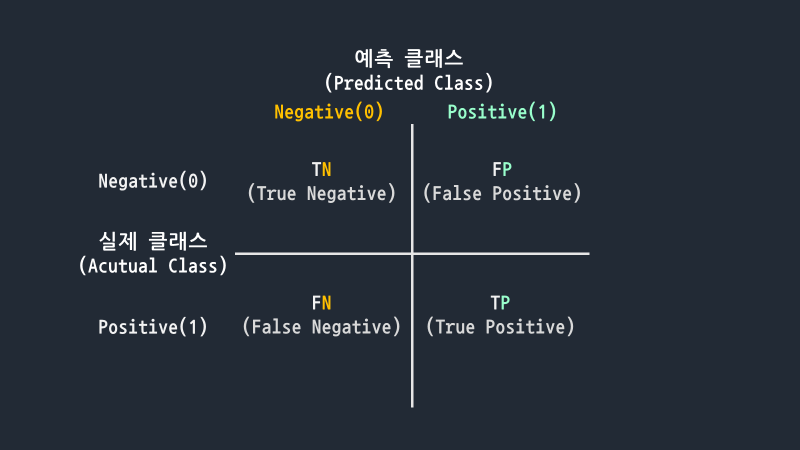

TN : 예측 값은 Negative(0)로 예측 했고, 실제 값 역시 Negative(0)

FP : 예측 값은 Positive(1)로 예측 했고, 실제 값은 Negative(0)

FN : 예측 값은 Negative(0)로 예측 했고, 실제 값은 Positive(1)

TP : 예측 값은 Positive(1)로 예측 했고, 실제 값은 Positive(1)


In [ ]:
#위에서의 예제를 confusion matrix로 평가
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, pred))
print(np.array([["TN","FP"],
       ["FN", "TP"]]))

[[405   0]
 [ 45   0]]
[['TN' 'FP']
 ['FN' 'TP']]


confusion_matrix로 정확도, 정밀도, 재현율을 알 수 있음

- 정확도 : (TN + TP) / (TN + TP + FN + FP)
- 정밀도 : (TP) / (TP + FP)
- 재현율 : (TN) / (TN + FP) or (TP) / (FN + TP)
  - 민감도(Sensitivity)또는 TPR(True Positive Rate)라고도 불림


재현율이 상대적으로 더 중요한 지표인 경우
  - 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생

정밀도가 상대적으로 더 중요한 지표인 경우
  - 실제 Negative 음성인 데이터 예측은 Positive로 잘못 판단하게 되면 업무상 큰 영향이 발생

In [ ]:
#정밀도 precision_score(), 재현율 recall_score()
#4가지 지표를 모두 호출하는 함수를 만듬

from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print("오차 행렬")
  print(confusion)
  print(f"정확도 : {round(accuracy, 4)}, 정밀도 : {round(precision, 4)}, 재현율 : {round(recall, 4)}")

In [31]:
#로지스틱 회귀 기반으로 타이타닉 생존자 예측
#평가 수행
train_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/titanic/train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/titanic/test.csv"

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
train = pd.read_csv(train_path)
X = train.drop("Survived", axis=1)
y = train["Survived"]

X = transform_features(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=11)

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율 : 0.7869, F1 : 0.7805, ROC AUC : 0.8341


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


##정밀도/재현율 트레이드오프(Trade-Off)관계

###$$정밀도(Precision)$$
$$\frac{TP}{TP + FP}$$

###$$재현율(Recall) = 민감도(Sensitivity)$$
$$\frac{TN}{TN+FP}\;or\;\frac{TP}{TP+FN}$$

In [ ]:
#predict_proba()

pred_proba = clf.predict_proba(X_test)
pred = clf.predict(X_test)
print("pred_proba()결과 Shape : {}".format(pred_proba.shape))
print("pred_proba array에서 앞 3개만 샘플로 추출 \n: ", pred_proba[:3])

#예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값 하눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)],axis=1)
print("두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n", pred_proba_result[:3])

In [ ]:
#사이킷런 로직을 직접 구현해 가기
#Binarizer 클래스 사용
#threshold 값을 기준으로 클래스를 분류
from sklearn.preprocessing import Binarizer

X=[[1,-1, 3],
   [2, 0, 0],
   [0, 1.1, 1.2]]

#X의 개별 원소들이 threshold값 보다 같거나 작으면 0을 크면 1을 반환
binarizer  = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


threshold = 1.1이며 1.1보다 값이 작거나 같으면 0을 크면 1을 반환한 것을 볼 수 있음

In [ ]:
#Binarizer를 이용하여 predict()의 의사코들르 만들기
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값, 분류 결정 임곗값임
custom_threshold = 0.5

#predict_proba() 반환값의 두 번째 칼럼 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold =custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율 : 0.7869


위에서 구한 지표들과 값이 정확하게 일치하는 것을 볼 수 있다.

이는 predict()가 predict_proba에 기반한 것을 보여준다.

In [ ]:
#임계치를 0.4로 낮추기
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold =custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.8324, 정밀도 : 0.7183, 재현율 : 0.8361


재현율이 올라가고 정밀도가 떨어지는 것을 볼 수 있다.



In [ ]:
#임계치를 0.4에서 0.6까지 0.05씩 증가
thresholds = [0.4, 0.45, 0.5,0.55,0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  #threshold list 객체 내의 값을 차례로 iteration하면서 평가 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold =custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print("임계치 : ", custom_threshold)
    get_clf_eval(y_test, custom_predict)
    print()

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


임계치 :  0.4
오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.8324, 정밀도 : 0.7183, 재현율 : 0.8361

임계치 :  0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492, 정밀도 : 0.7656, 재현율 : 0.8033

임계치 :  0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율 : 0.7869

임계치 :  0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659, 정밀도 : 0.8364, 재현율 : 0.7541

임계치 :  0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771, 정밀도 : 0.8824, 재현율 : 0.7377



In [ ]:
#사이킷런에서는 precision_recall_curve() API를 제공
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = clf.predict_proba(X_test)[:, 1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반환된 분류 결정 임계치 배열의 Shape : ", thresholds.shape)

#반환된 임계치 배열 로우가 147건이므로 샘플로 10건만 추출, 임계치를 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print("샘플 추출을 위한 임계치 배열의 index 10개 : ", thr_index)
print("샘플용 10개의 임계치 : ", np.round(thresholds[thr_index], 2))

#15 Step 단위로 추출된 임계치에 따른 정밀도와 재현율 값
print("샘플 임계치별 정밀도 : ", np.round(precisions[thr_index],3))
print("샘플 임계치별 재현율 : ", np.round(recalls[thr_index],3))

반환된 분류 결정 임계치 배열의 Shape :  (143,)
샘플 추출을 위한 임계치 배열의 index 10개 :  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계치 :  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계치별 정밀도 :  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계치별 재현율 :  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


위의 결과를 그래프로 그려보기

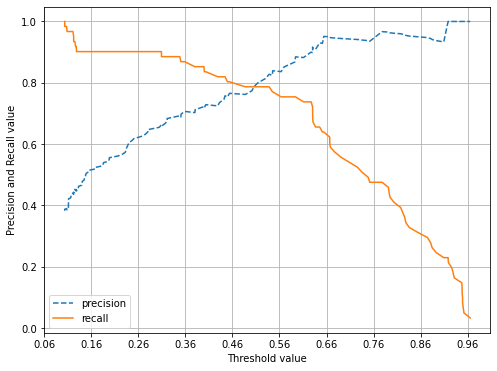

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test, pred_proba_c1):
  #threshold, ndarray와 이 thershold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds, precision_recall_curve(y_test, pred_proba_c1)

  #X축을 thershold값으로 Y축은 정밀도, 재현율 값으로 각각 Plot을 수행, 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label="precision")
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  #thershold값 X축의 Scale을 0.1단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1),2))

  #X축, Y축 label과 legend, 그리고 grid 설정
  plt.xlabel("Threshold value")
  plt.ylabel("Precision and Recall value")
  plt.legend()
  plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, pred_proba_class1)


###$$F1 Score$$
$$\frac{2 * precision * recall}{precision + recall}$$

$$정밀도와 재현율을 결합한 지표$$





In [4]:
#@title
#위에서 했던 작업들을 수행하기 편하게 함수로 정리

#Null(결측값)처리
def fillna(df):
  df["Age"] = df["Age"].fillna(df["Age"].mean())
  df["Cabin"] = df['Cabin'].fillna("N")
  df["Embarked"] = df["Embarked"].fillna("N")
  df["Fare"] = df["Fare"].fillna(0)

  return df

#불필요한 속성 제거
def drop_features(df):
  drop_col = ["PassengerId", "Name", "Ticket"]
  df.drop(drop_col, axis=1, inplace = True)
  return df

#LabelEncoding 수행

def format_features(df):
  from sklearn.preprocessing import LabelEncoder
  df["Cabin"] = df["Cabin"].str[:1]
  features = ["Cabin", "Sex","Embarked"]
  for feature in features:
    encoder = LabelEncoder()
    encoder.fit(df[feature])
    df[feature] = encoder.transform(df[feature])
  return df

#위에서 작성한 함수를 실행하는 함수
def transform_features(df):
  fillna(df)
  drop_features(df)
  format_features(df)
  return df

In [ ]:
#@title

#로지스틱 회귀 기반으로 타이타닉 생존자 예측
#평가 수행
train_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/titanic/train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/titanic/test.csv"

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
train = pd.read_csv(train_path)
X = train.drop("Survived", axis=1)
y = train["Survived"]

X = transform_features(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=11)

clf = LogisticRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_proba = clf.predict_proba(X_test)

In [10]:
from sklearn.metrics import f1_score
f1 =f1_score(y_test, pred)
print("F1 스코어 : ", round(f1, 4))


F1 스코어 :  0.7805


In [13]:
#정밀도 precision_score(), 재현율 recall_score()
#4가지 지표를 모두 호출하는 함수를 만듬
#F1 스코어를 추가
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import Binarizer
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  print("오차 행렬")
  print(confusion)
  print(f"정확도 : {round(accuracy, 4)}, 정밀도 : {round(precision, 4)}, 재현율 : {round(recall, 4)}, F1 : {round(f1, 4)}")

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  #threshold list 객체 내의 값을 차례로 iteration하면서 평가 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold =custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print("임계치 : ", custom_threshold)
    get_clf_eval(y_test, custom_predict)
    print()



In [14]:
#임계치를 0.4에서 0.6까지 0.05씩 증가
thresholds = [0.4, 0.45, 0.5,0.55,0.60]


get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계치 :  0.4
오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.8324, 정밀도 : 0.7183, 재현율 : 0.8361, F1 : 0.7727

임계치 :  0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492, 정밀도 : 0.7656, 재현율 : 0.8033, F1 : 0.784

임계치 :  0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율 : 0.7869, F1 : 0.7805

임계치 :  0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659, 정밀도 : 0.8364, 재현율 : 0.7541, F1 : 0.7931

임계치 :  0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771, 정밀도 : 0.8824, 재현율 : 0.7377, F1 : 0.8036



###ROC CURVE(수신자 판단 곡선) and AUC

: FPR(False Positive Rate)가 변할때 TPR(True Positive Rate)가 어떻게 변하는지 나타내는 곡선

- FPR : 1 - 특이도(Specificity)(TNR)
  - X축에 위치
  - $1-TNR\,:\,1 - \frac{TN}{TN+FP}\quad or \quad FPR\,:\,\frac{FP}{FP+TN}$   
- TPR : 민감도(Sensitivity)
  - Y축에 위치
  - $TPR\,:\,\frac{TP}{FN+TP}$



In [18]:
#roc_curve() 사용
#주요 파라미터 는 y_true, y_score : predict_proba()반환값 array에서 Positive 칼럼 예측 확률
#반환값 : fpr, tpr, thresholds

from sklearn.metrics import roc_curve
import numpy as np
#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class = clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class)
#반환된 임계값 배열로우가 47건이므로 샘플로 10건만 추출하고, 임계값 5 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 5)
print("샘플 추출을 위한 임계값 배열의 index 10개 : ",thr_index)
print("샘플용 10개의 임계값 : ", np.round(thresholds[thr_index],2))

#5 Step 단위로 추출된 임계값에 따른 FRP, TPR 값
print("샘플 임계값별 FPR : ", np.round(fprs[thr_index],3))
print("샘플 임계값별 TPR : ", np.round(tprs[thr_index],3))

샘플 추출을 위한 임계값 배열의 index 10개 :  [ 0  5 10 15 20 25 30 35 40 45 50]
샘플용 10개의 임계값 :  [1.97 0.75 0.63 0.59 0.49 0.4  0.35 0.23 0.13 0.12 0.11]
샘플 임계값별 FPR :  [0.    0.017 0.034 0.051 0.127 0.161 0.203 0.331 0.585 0.636 0.797]
샘플 임계값별 TPR :  [0.    0.475 0.689 0.754 0.787 0.836 0.869 0.902 0.918 0.967 0.967]


결과를 확인하니 임계값이 1에서 가까운 값에서 점점 작아지면서 FPR이 점점 커짐

FPR이 조금씩 커질때, TPR은 가파르게 커짐

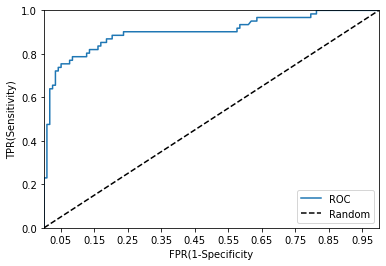

In [23]:
#ROC 커브를 시각화
import matplotlib.pyplot as plt

def roc_curve_plot(y_test, pred_proba_c1):
  #임계값에 따른 FPR, TPR 값 반환받음
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  #ROC 곡선을 그래프 곡선으로 그림
  plt.plot(fprs, tprs, label="ROC")
  #가운데 대각선 그림
  plt.plot([0,1],[0,1],'k--',label='Random')


  #FPR X축의 Scale을 0.1 단위로 변경 X,Y축 명 설정
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1),2))
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.xlabel("FPR(1-Specificity")
  plt.ylabel("TPR(Sensitivity)")
  plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

일반적으로 ROC 곡선 자페는 FRP과 TPR의 변화 값을 보는데 이용하며 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값으로 결정

AUC 값은 1에 가까우면 좋고 0.5이상이다.
- FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있는가

In [26]:
from sklearn.metrics import roc_auc_score

pred = clf.predict(X_test)
pred_proba = clf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred)
print("ROC AUC 값 : ",round(roc_score, 4))

ROC AUC 값 :  0.8341


In [27]:
#정밀도 precision_score(), 재현율 recall_score()
#4가지 지표를 모두 호출하는 함수를 만듬
#F1 스코어를 추가
#ROC AUC도 추가

from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import Binarizer
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_score = roc_auc_score(y_test, pred)
  print("오차 행렬")
  print(confusion)
  print(f"정확도 : {round(accuracy, 4)}, 정밀도 : {round(precision, 4)}, 재현율 : {round(recall, 4)}, F1 : {round(f1, 4)}, ROC AUC : {round(roc_score, 4)}")



def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  #threshold list 객체 내의 값을 차례로 iteration하면서 평가 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold =custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print("임계치 : ", custom_threshold)
    get_clf_eval(y_test, custom_predict)
    print()



In [30]:
thresholds = [0.4, 0.45, 0.5,0.55,0.60]

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임계치 :  0.4
오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.8324, 정밀도 : 0.7183, 재현율 : 0.8361, F1 : 0.7727, ROC AUC : 0.8333

임계치 :  0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492, 정밀도 : 0.7656, 재현율 : 0.8033, F1 : 0.784, ROC AUC : 0.8381

임계치 :  0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율 : 0.7869, F1 : 0.7805, ROC AUC : 0.8341

임계치 :  0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659, 정밀도 : 0.8364, 재현율 : 0.7541, F1 : 0.7931, ROC AUC : 0.8389

임계치 :  0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771, 정밀도 : 0.8824, 재현율 : 0.7377, F1 : 0.8036, ROC AUC : 0.8434

